# SODA 3.4.2 Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [13]:
client.close()
cluster.close()

In [29]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.3dbd0ad7ce8b4d47a093888d67834d57 Dashboard: /services/dask-gateway/clusters/staging.3dbd0ad7ce8b4d47a093888d67834d57/status,Cluster Workers: 20 Cores: 40 Memory: 160.00 GiB


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import xmitgcm
import xgcm
xr.set_options(display_style='text')

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

#with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
#    topo = xr.open_dataset(fp)

In [5]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

## <font color='Green'>Slice to WG region</font>

In [6]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [7]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [ ]:
topo.ds_10_12_T

In [ ]:
topo.depth

In [8]:
ds_wg = ocean.isel(**lat_range, **lon_range)
#depth_wg = topo.depth.isel(**lat_range_top, **lon_range_top)

In [ ]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

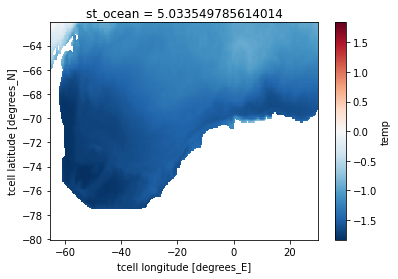

In [9]:
#testing to see if correctly sliced desired region
sst_mean = ds_wg.temp.isel(st_ocean=0).mean(dim='time')
sst_mean.plot()

## <span style='color:Red'> Bottom Potential Temperatures

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() & ds_wg.temp.st_ocean.max())

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull()) & ds_wg.temp.st_ocean.max()

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() is True).argmax(dim='st_ocean')[0].plot()

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() is True) and ds_wg.temp.idxmax(dim='st_ocean')

In [ ]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull() is True)

In [ ]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull()).argmax(dim='st_ocean')

In [ ]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull()).idxmax(dim='st_ocean')

In [ ]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull())[0, -1].plot()

In [ ]:
ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull()).where(ds_wg.temp.notnull().max(dim='st_ocean'))

In [9]:
#999 is ocean, 111 is land
hfacc = ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull(), 999).where(ds_wg.temp < 999, 111)

In [10]:
#999 is ocean, 111 is land
depth_max = (ds_wg.st_ocean.where(hfacc == 999)).max(dim='st_ocean').load()

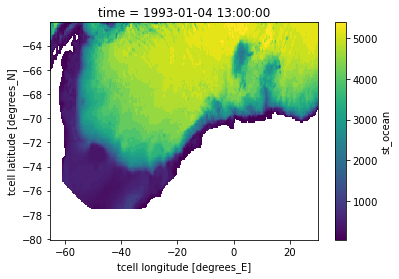

In [15]:
depth_max[0].plot()

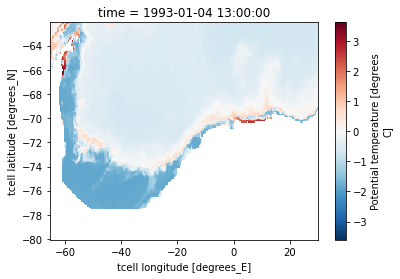

In [18]:
ds_wg.temp[0].sel(st_ocean=depth_max[0], method='nearest').plot()

In [12]:
temp_mean = ds_wg.temp.mean(dim='time').load()

In [16]:
temp_mean.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [17]:
depth_max.mean(dim='time').coords

Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [19]:
bottom_temp = temp_mean.sel(st_ocean=depth_max.mean(dim='time'), method='nearest')#.plot()

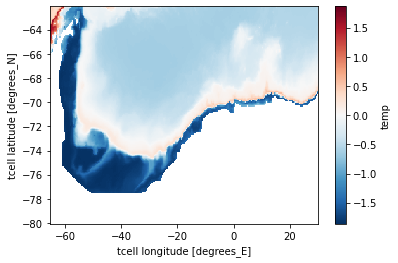

In [21]:
bottom_temp.plot()

In [22]:
ds_wg.xt_ocean

<xarray.DataArray 'xt_ocean' (xt_ocean: 381)>
array([-65.125, -64.875, -64.625, ...,  29.375,  29.625,  29.875])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
Attributes:
    cartesian_axis:  X
    long_name:       tcell longitude
    units:           degrees_E

In [24]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


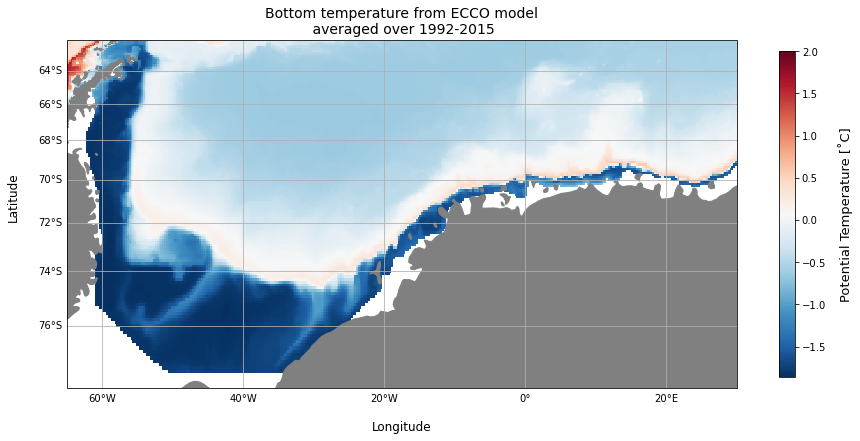

In [25]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from ECCO model\n averaged over 1992-2015', fontsize=14);

In [ ]:
hfacc

In [ ]:
hfacc[0,-10].plot()

In [ ]:
depth_max100 = ds_wg.st_ocean.where(hfacc.isel(time=100) == 999).isel(st_ocean=-10)#.max(dim='st_ocean')
depth_max100.load()
depth_max100.plot()

In [ ]:
depth_max100 = (ds_wg.st_ocean.where(hfacc.isel(time=100) == 999)).max(dim='st_ocean')
depth_max100.load()
depth_max100.plot()

In [ ]:
depth_max100.isel(yt_ocean=-1, xt_ocean=-1)

In [ ]:
ds_wg.st_ocean.sel(st_ocean=5185.11083984, method='nearest')

In [ ]:
ds_wg.temp.isel(time=100).sel(st_ocean=depth_max100, method='nearest').plot()

In [ ]:
ds_wg.st_ocean

In [ ]:
ds_wg.temp.isel(time=100).sel(st_ocean=depth_max100.astype('i4'))

In [ ]:
ds_wg.temp.st_ocean.max(dim='st_ocean').where(ds_wg.temp == ds_wg.temp.notnull()).where(ds_wg.temp.notnull().max(dim='st_ocean'))[0].sum('st_ocean').plot()

In [ ]:
ds_wg.temp.st_ocean.max(dim='st_ocean').where(ds_wg.temp == ds_wg.temp.notnull()).where(ds_wg.temp.notnull().max(dim='st_ocean'))[0,-1]#.plot()

In [ ]:
ds_wg.temp.notnull().idxmax(dim='st_ocean')#[0].plot()

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull()).argmax(dim='st_ocean')[0].plot()

In [ ]:
#this gives us the deargmaxf the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

In [ ]:
ds_wg.temp.st_ocean.max()

In [ ]:
#this gives us the depth of the bottom cell
depth_max = ds_wg.st_ocean.where(depth_wg.max()).max(dim='st_ocean').load()

In [ ]:
ds_wg.temp.shape

In [ ]:
depth_wg.shape

In [ ]:
ds_wg.temp[0,-1,:,:].plot()

In [ ]:
ds_wg.temp.st_ocean.max()

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() & ds_wg.temp.st_ocean.max())

In [ ]:
depth_wg.plot()

In [ ]:
depth_max.plot()

In [ ]:
bottom_temp = ds_wg.temp.sel(st_ocean=depth_max)#.fillna(0.).astype('i4'))
bottom_temp

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [26]:
temp_std = (ds_wg.temp.sel(st_ocean=depth_max.mean(dim='time'), method='nearest')).std(dim='time')

KeyboardInterrupt: 

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)